# Predicting Discharge Reference Capacity using Voltage Rebound Information 

**NOTE**: Using parameters estimated from a logisitic-like function fit on the rebound curve, as well as max measured temp in celsius.

**NOTE**: This analysis does not take into account a cell's cycle history, therefore time is not a predictor and is not considered in this analysis.

**NOTE**: Definitions for logisitc-like estimated parameters:
  
*  L: Asymptotic maximum value  
*  A: Scaling factor  
*  x0: Midpoint of the curve  
*  b: Growth rate  

In [1]:
# load packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
n45_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa45_WORSTsubset30.csv')
n47_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa47_WORSTsubset30.csv')
n48_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa48_WORSTsubset30.csv')

In [3]:
n_all = pd.concat([n45_sub, n47_sub, n48_sub], axis = 0)

In [4]:
print(n_all.shape)

(207, 8)


In [5]:
n_all.head()

Step         L         A         x0         b  Reference Capacity  \
0   0.0  3.784006  1.794006  18.200941  0.851983            4356.636   
1   4.0  3.184107  1.197107   9.733744  2.397092            3856.567   
2   6.0  3.232201  1.244201   9.791735  2.378526            3703.252   
3   8.0  3.238709  1.269709   9.808275  2.361966            3594.173   
4  10.0  3.311926  1.328926   9.720198  1.886580            3506.276   

   Max_Temp  Ambient_Temperature  
0    15.710                  4.0  
1    16.327                  4.0  
2    16.190                  4.0  
3    16.445                  4.0  
4    16.652                  4.0

In [6]:
n_all = n_all.drop(columns = ['Ambient_Temperature', 'Step', 'Max_Temp'])

In [7]:
n_all.isnull().sum()

L                     0
A                     0
x0                    0
b                     0
Reference Capacity    0
dtype: int64

In [8]:
n_all = n_all.dropna()

In [9]:
n_all.duplicated().any()

False

In [10]:
n_all.head()

L         A         x0         b  Reference Capacity
0  3.784006  1.794006  18.200941  0.851983            4356.636
1  3.184107  1.197107   9.733744  2.397092            3856.567
2  3.232201  1.244201   9.791735  2.378526            3703.252
3  3.238709  1.269709   9.808275  2.361966            3594.173
4  3.311926  1.328926   9.720198  1.886580            3506.276

In [11]:
n_all.tail()

L         A        x0         b  Reference Capacity
63  3.170121  0.484121  7.766694  3.227321            4679.544
64  3.193998  0.494998  7.838364  3.234326            4568.834
65  3.202677  0.512677  7.838959  3.236978            4519.852
66  3.190154  0.506154  7.791413  3.232986            4507.155
67  3.207044  0.517044  7.870066  3.238898            4403.258

In [12]:
n_all.describe()

L           A          x0           b  Reference Capacity
count  207.000000  207.000000  207.000000  207.000000          207.000000
mean     3.360039    0.978034   10.111034    2.150711         4099.555184
std      0.279760    0.492438    5.362373    1.545892          867.215342
min      2.936749    0.484121    0.001998    0.471447         2678.509000
25%      3.201553    0.607182    7.247977    1.124336         3127.438500
50%      3.277234    0.758868    7.713616    1.535409         4359.665000
75%      3.360092    1.326461   10.655774    3.138224         4654.944500
max      4.118639    2.132101   45.611969    9.572193         6134.145000

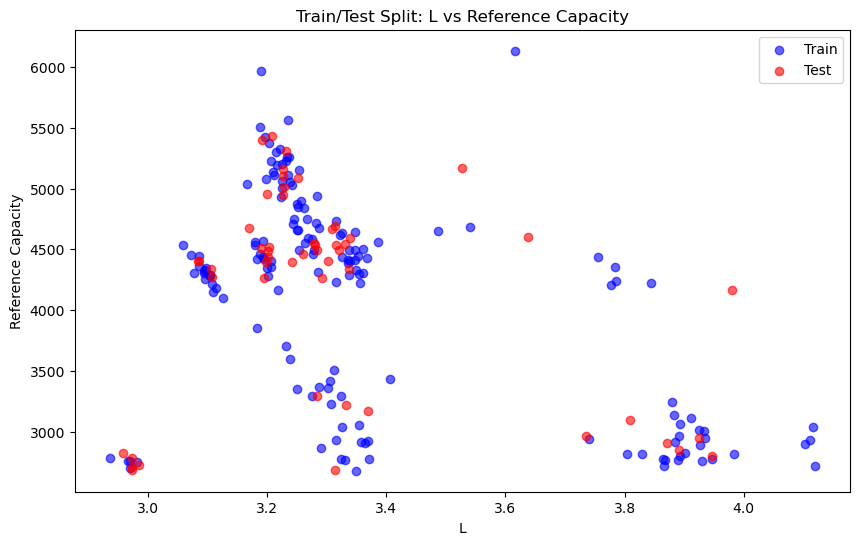

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features (X) and target (y)
y = n_all["Reference Capacity"]  # Target
X = n_all.drop('Reference Capacity', axis = 1) # Features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot training points in blue
plt.scatter(X_train['L'], y_train, color="blue", label="Train", alpha=0.6)

# Plot testing points in red
plt.scatter(X_test['L'], y_test, color="red", label="Test", alpha=0.6)

# Add labels, legend, and title
plt.xlabel("L")
plt.ylabel("Reference Capacity")
plt.title("Train/Test Split: L vs Reference Capacity")
plt.legend()
plt.show()

In [14]:
print(X_train.shape, y_train.shape)
print('\n', X_test.shape, y_test.shape)

(155, 4) (155,)

 (52, 4) (52,)


In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Polynomial Degree 2": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Linear Regression
  RMSE (folds): [434.5795963671911, 416.83443824481327, 467.2512243073812, 455.84978707538386, 381.18162709840243]
  MAE (folds): [319.2671527327715, 352.6802597956236, 376.7056608192868, 326.5440152561661, 283.2532840929361]
  Average RMSE: 431.1393
  Average MAE: 331.6901
--------------------------------------------------
Evaluating: Ridge Regression
  RMSE (folds): [432.0041663307825, 423.34267988977103, 465.0482942046313, 453.2785438469254, 384.52767279509067]
  MAE (folds): [313.57121009768053, 355.21374415179866, 373.34528656769015, 323.25913479034193, 282.93232765143813]
  Average RMSE: 431.6403
  Average MAE: 329.6643
--------------------------------------------------
Evaluating: Lasso Regression
  RMSE (folds): [434.50910171865877, 416.84643079344386, 467.2299585204651, 455.9005003160165, 381.2306926379871]
  MAE (folds): [319.17150847960545, 352.6515666172142, 376.6222591439433, 326.52633384418215, 283.2631203712073]
  Average RMSE: 431.1433
  Av

In [17]:
models.keys()

dict_keys(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Polynomial Degree 2'])

In [18]:
models['Elastic Net'].coef_

array([ 232.08863759, -983.07073582,  182.86624743,   -9.31573311])

In [19]:
models['Elastic Net'].intercept_

4082.726384286143

In [20]:
X_train_scaled

array([[-0.01820291,  0.72410129, -0.08875798, -0.32857745],
       [ 1.88231987,  1.80683677,  1.17099439, -0.77404752],
       [-0.29345783,  0.6223977 ,  0.08708185,  0.0060145 ],
       [-0.43537876, -0.46014941, -0.65011774, -0.54522749],
       [-0.12725001, -0.69389086, -0.57627284, -0.56393444],
       [-0.32084354, -0.79506336, -0.69177602, -0.40031935],
       [ 0.11179404,  0.83492155, -0.02589621, -0.37247044],
       [-0.93560236, -0.7776005 , -0.51329867,  0.63638611],
       [ 1.59538768,  1.64516165,  1.14103824, -0.74210507],
       [-0.94757276, -0.77445798, -0.52858625,  0.62905516],
       [ 1.44302244,  0.57254938,  3.07724315, -1.00553729],
       [-0.52769776, -0.92743746, -0.18668599,  1.43712507],
       [-0.1369058 , -0.32163364, -0.47555705, -0.71447216],
       [-0.04604081, -0.66988485, -0.62621429, -0.62639099],
       [ 2.55213925,  2.20996111,  2.18653898, -0.85215604],
       [-0.35082408,  0.5604119 , -0.08576997, -0.17255931],
       [ 1.80954723,  1.

In [21]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Models to evaluate
models = {
    "SVM with RBF Kernel": SVR(kernel='rbf'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: SVM with RBF Kernel
  RMSE (folds): [816.2844518984629, 947.8212758889292, 854.6590082132533, 960.054150566411, 895.7385088948531]
  MAE (folds): [606.972356509786, 746.0281251294648, 660.9537494877351, 752.7148857379364, 722.6982243176566]
  Average RMSE: 894.9115
  Average MAE: 697.8735
--------------------------------------------------
Evaluating: Decision Tree
  RMSE (folds): [327.68984502845717, 215.0514452073603, 173.0692523620568, 333.49361275113864, 272.9815723658922]
  MAE (folds): [181.46200000000007, 142.87609677419366, 125.78103225806457, 189.68516129032255, 179.09625806451606]
  Average RMSE: 264.4571
  Average MAE: 163.7801
--------------------------------------------------
Evaluating: Random Forest
  RMSE (folds): [357.6088469508925, 141.0306251578392, 196.2820605035478, 358.3104271534182, 225.87662297315714]
  MAE (folds): [179.5881532258067, 112.0939058064518, 142.9388987096773, 190.56671612903267, 147.26882645161317]
  Average RMSE: 255.8217
  Average MAE:

In [22]:
from sklearn.model_selection import GridSearchCV
import joblib  # To save the model

# Models to evaluate
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Hyperparameter grids
param_grids = {

    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, param_grid, X, y):
    rmse_scores = []
    mae_scores = []
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    
    # Save the best model for Random Forest
    if isinstance(best_model, RandomForestRegressor):
        joblib.dump(best_model, 'best_random_forest_model.joblib')
        print("Best Random Forest model saved as 'best_random_forest_model.joblib'")

    # Save the best model for Decision Tree
    if isinstance(best_model, DecisionTreeRegressor):
        joblib.dump(best_model, 'best_decision_tree_model.joblib')
        print("Best Decision Tree model saved as 'best_decision_tree_model.joblib'")
    
    # Evaluate the best model using cross-validation
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        best_model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = best_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Get the hyperparameter grid for the model
    param_grid = param_grids[name]
    
    # Evaluate the model with hyperparameter tuning
    rmse_scores, mae_scores = evaluate_model(model, param_grid, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Decision Tree
Best parameters for DecisionTreeRegressor(random_state=42): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Decision Tree model saved as 'best_decision_tree_model.joblib'
  RMSE (folds): [325.41632566459634, 215.2488364125758, 166.7634229242955, 349.0368978538335, 252.38384131559778]
  MAE (folds): [181.0864731182796, 140.70751612903237, 126.78027419354848, 221.44088709677416, 158.6669677419354]
  Average RMSE: 261.7699
  Average MAE: 165.7364
--------------------------------------------------
Evaluating: Random Forest
Best parameters for RandomForestRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest model saved as 'best_random_forest_model.joblib'
  RMSE (folds): [354.536701808626, 131.78569850210295, 199.26940387120823, 351.8509019805653, 224.60275067177255]
  MAE (folds): [174.369463225807, 104.7153135483873, 143.50388838709685, 188.4015038709676, 145.08

In [23]:
models['Random Forest'].fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [24]:
testpred = models['Random Forest'].predict(X_test_scaled)

In [25]:
import numpy as np

In [26]:
4.8,11,31

(4.8, 11, 31)

In [27]:
xnew = X_test*np.random.normal([1,1,1,1],[.04,.08,.11,.31])

In [28]:
xnew - X_test

L         A        x0         b
22 -0.174997  0.026788 -1.233963  0.939985
15 -0.176256  0.059297 -1.830907  1.185721
3  -0.169673  0.032485 -1.244724  0.775977
26 -0.173473  0.034226 -1.285147  0.704106
27 -0.175405  0.027475 -1.250597  0.840749
9  -0.173700  0.057709 -1.811379  1.314086
30 -0.174621  0.035568 -1.313661  0.685638
65 -0.163227  0.026327 -1.413509  1.957376
18 -0.201410  0.079429 -2.750030  0.595883
9  -0.170633  0.023488 -1.722642  2.782958
32 -0.175306  0.027699 -1.270625  0.710272
30 -0.204740  0.082094 -3.028504  0.552426
16 -0.170700  0.024111 -2.014289  4.459540
66 -0.168716  0.022122 -1.435721  2.013440
55 -0.164303  0.026735 -1.377892  1.951251
57 -0.169118  0.022367 -1.421526  2.013170
25 -0.176602  0.028639 -1.228388  0.721344
50 -0.169005  0.022230 -1.398607  2.010643
14 -0.171966  0.033243 -1.253990  0.752151
5  -0.170965  0.033334 -1.216536  0.737408
54 -0.163112  0.026451 -1.376336  1.948522
31 -0.172478  0.025274 -1.489615  1.428526
34 -0.192427  0.051157 -3.061163  0.366636
31 -0.171451  0.033473 -1.317605  0.855493
69 -0.157267  0.043911 -1.377921  1.954570
25 -0.207593  0.084889 -3.093047  0.549334
25 -0.173390  0.034245 -1.274533  0.729810
16 -0.178174  0.060795 -1.834373  1.084012
2  -0.168831  0.022566 -1.683060  2.751742
45 -0.176503  0.028033 -1.368002  0.792999
15 -0.170707  0.023592 -1.828615  3.195560
68 -0.157262  0.043425 -1.377682  1.954451
66 -0.157304  0.043285 -1.378182  1.954488
50 -0.210490  0.065474 -8.404904  0.293608
8  -0.170637  0.023665 -1.704200  2.759379
28 -0.173656  0.034902 -1.320564  0.692220
68 -0.164364  0.026611 -1.415169  1.960368
28 -0.176165  0.028190 -1.246119  0.728336
45 -0.208701  0.085324 -3.325385  0.525487
43 -0.174141  0.035871 -1.369888  0.737700
65 -0.156428  0.042955 -1.372269  1.952279
38 -0.175616  0.027256 -1.326928  0.862170
16 -0.169200  0.031089 -1.284240  1.047719
63 -0.167657  0.021159 -1.431166  2.009912
67 -0.157858  0.043569 -1.375082  1.955401
12 -0.186500  0.045779 -2.721229  0.379841
65 -0.169379  0.022407 -1.444483  2.015927
54 -0.169317  0.022226 -1.407193  2.012124
38 -0.205775  0.083343 -3.060776  0.564106
24 -0.197551  0.076371 -2.480362  0.628348
60 -0.175316  0.058477 -1.998830  1.276366
55 -0.169334  0.022764 -1.411453  2.010153

In [29]:
xnew = scaler.transform(xnew)

In [30]:
testprednew = models['Random Forest'].predict(xnew)
testprednew

array([4564.15919, 3145.63638, 5081.74581, 5066.18264, 4557.37289,
       3138.00014, 5059.19625, 3990.17207, 2910.21498, 4493.026  ,
       4578.5568 , 2906.96011, 5147.38243, 4322.3442 , 3989.78867,
       4450.8291 , 4822.30733, 4384.2249 , 5076.58387, 5079.89172,
       3990.17207, 4484.69461, 3072.77108, 5058.70781, 2773.34937,
       2906.96011, 5071.40728, 3145.63638, 4366.86944, 4701.11855,
       4523.21117, 2773.34937, 2773.34937, 3552.29598, 4468.09853,
       5062.99081, 3990.17207, 4693.74415, 2916.1734 , 5060.0043 ,
       2773.34937, 4562.69179, 5055.48607, 4059.93174, 2773.34937,
       3453.5136 , 4472.73114, 4472.73114, 2906.96011, 2893.64441,
       3247.83207, 4476.00754])

In [31]:
testpred

array([4728.47474, 3241.02354, 5286.45961, 4622.82741, 4646.26975,
       3351.99321, 4461.18228, 4370.84294, 2844.95073, 5140.12135,
       4654.53536, 2862.56558, 5170.52824, 4426.16256, 4258.88343,
       4390.88397, 4594.00345, 4357.33487, 4831.6065 , 5196.59978,
       4392.33711, 4701.77883, 5121.01273, 4871.10446, 2745.98475,
       2942.94319, 4639.27789, 3209.098  , 5444.22899, 4353.07947,
       5167.51086, 2744.70873, 2754.07639, 4181.09402, 5148.85609,
       4492.19046, 4284.87576, 4578.09583, 2963.80685, 4348.69971,
       2766.75495, 4579.42362, 5105.12662, 4528.03797, 2745.07647,
       4697.69119, 4389.96183, 4347.78493, 2906.36522, 2959.40789,
       2855.73895, 4382.06167])

In [32]:
from sklearn.metrics import mean_absolute_percentage_error

In [33]:
mean_absolute_percentage_error(testpred, testprednew)

0.0645205191581524

DecisionTreeRegressor(random_state=42) 274.86754860617725
RandomForestRegressor(random_state=42) 155.04703622392205
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 188.19781032403705


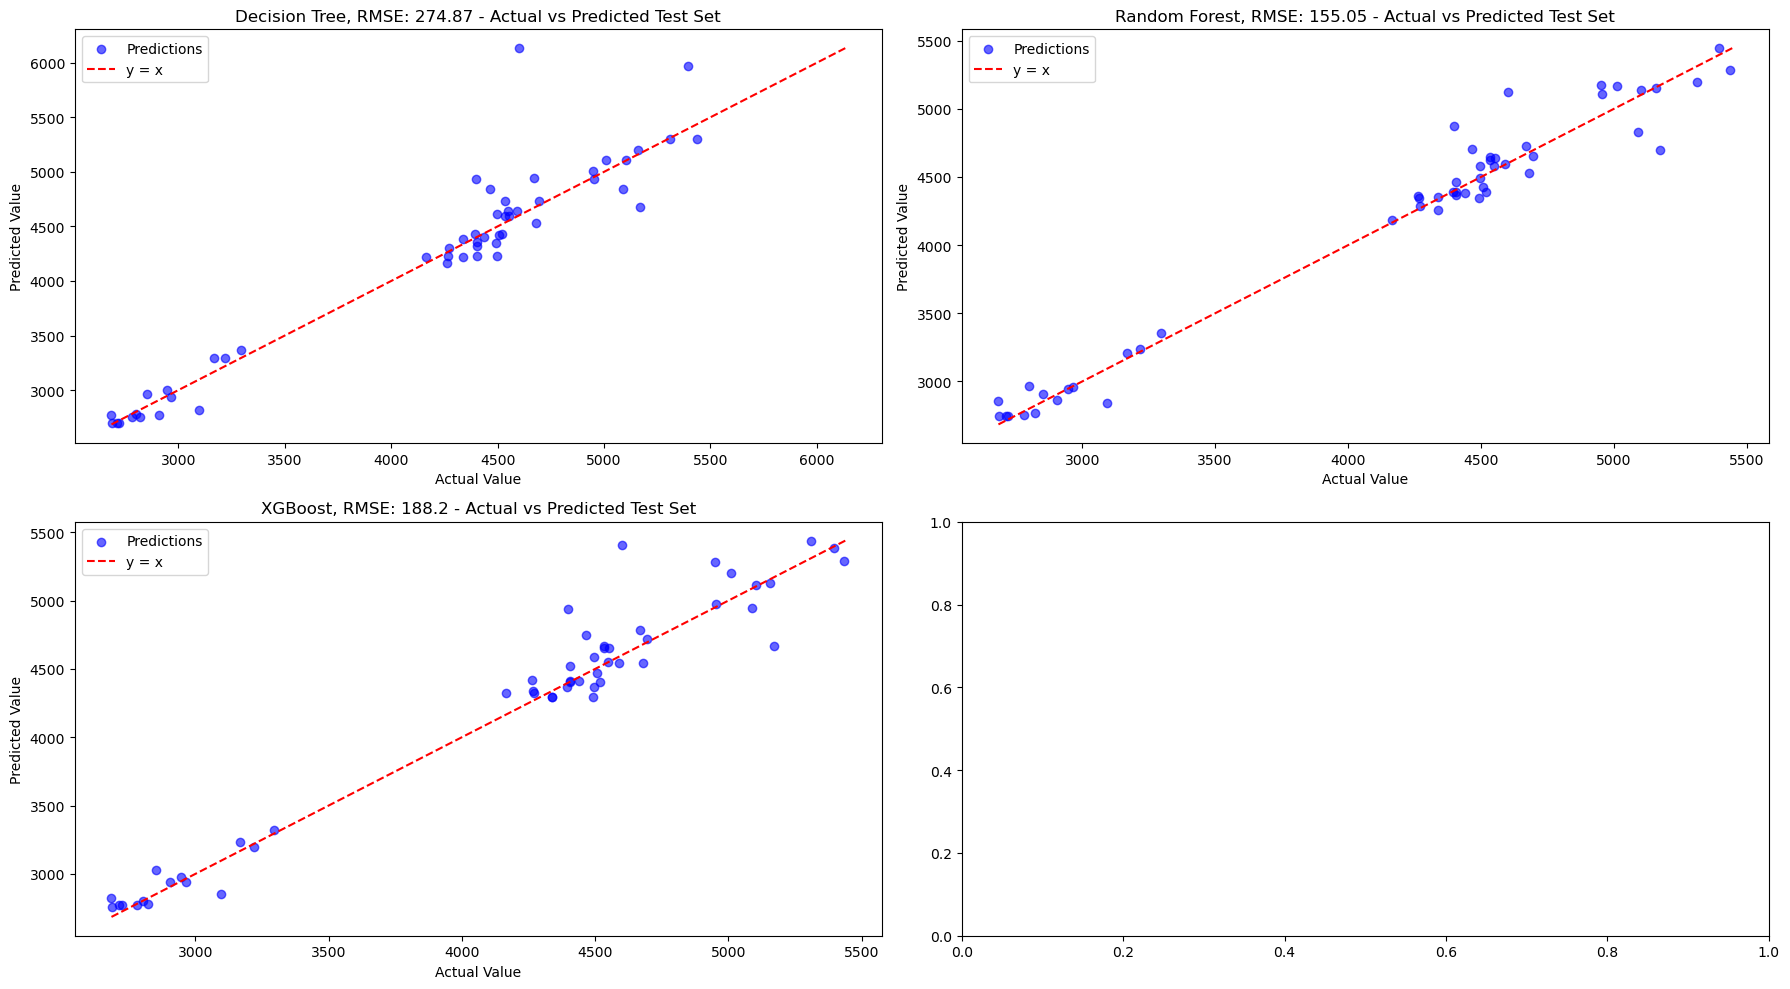

In [34]:
# Define the feature names
features = ['L', 'A', 'x0', 'b']

# Create a subplot grid (1x2)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# List to store RMSE values for each model
rmse_values = []

# Convert y_test to numpy for plotting
y_test_np = y_test.to_numpy()

# Fit each model, extract coefficients, and plot
for i, (name, model) in enumerate(models.items()):
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Calculate RMSE for the current model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    rmse_values.append(rmse)

    print(model, rmse)

    # Plot Actual vs Predicted
    axes[i].scatter(y_test_np, y_pred, label='Predictions', color='blue', alpha=0.6)
    
    # Plot the "actual = predicted" line (y = x line)
    min_val = min(np.min(y_test_np), np.min(y_pred))
    max_val = max(np.max(y_test_np), np.max(y_pred))
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y = x")
    
    # Set titles and labels
    axes[i].set_title(f'{name}, RMSE: {rmse.round(2)} - Actual vs Predicted Test Set')
    axes[i].set_xlabel('Actual Value')
    axes[i].set_ylabel('Predicted Value')
    axes[i].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [35]:
# List to store percentage RMSE values
percent_rmse_values = {}

# Convert y_test to numpy for easier handling
y_test_np = y_test.to_numpy()

# Evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    # Calculate percentage RMSE
    mean_actual = np.mean(y_test_np)
    percent_rmse = (rmse / mean_actual) * 100
    
    # Store the percentage RMSE
    percent_rmse_values[name] = percent_rmse

# Print out the percentage RMSE for each model
for name, percent_rmse in percent_rmse_values.items():
    print(f"{name} - Percentage RMSE: {percent_rmse:.2f}%")

Decision Tree - Percentage RMSE: 6.63%
Random Forest - Percentage RMSE: 3.74%
XGBoost - Percentage RMSE: 4.54%


Even though larger time windows (full or 180 seconds) usually offer more data per step, the fact that smaller windows still produce low errors indicates that the early behavior captured by the logistic-like function is very effective at predicting the discharge reference capacity.

In [36]:
features

['L', 'A', 'x0', 'b']

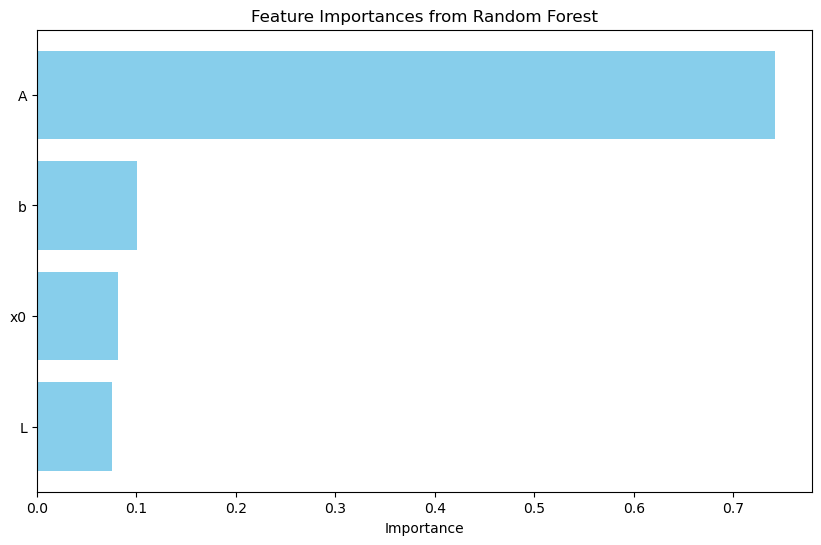

In [37]:
best_model = joblib.load('best_random_forest_model.joblib')

# Get feature importances from the model
importances = best_model.feature_importances_

# Create a DataFrame for better visualization (optional, but can make it easier to view)
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances by value
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.savefig('random_forest_nasa.png')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

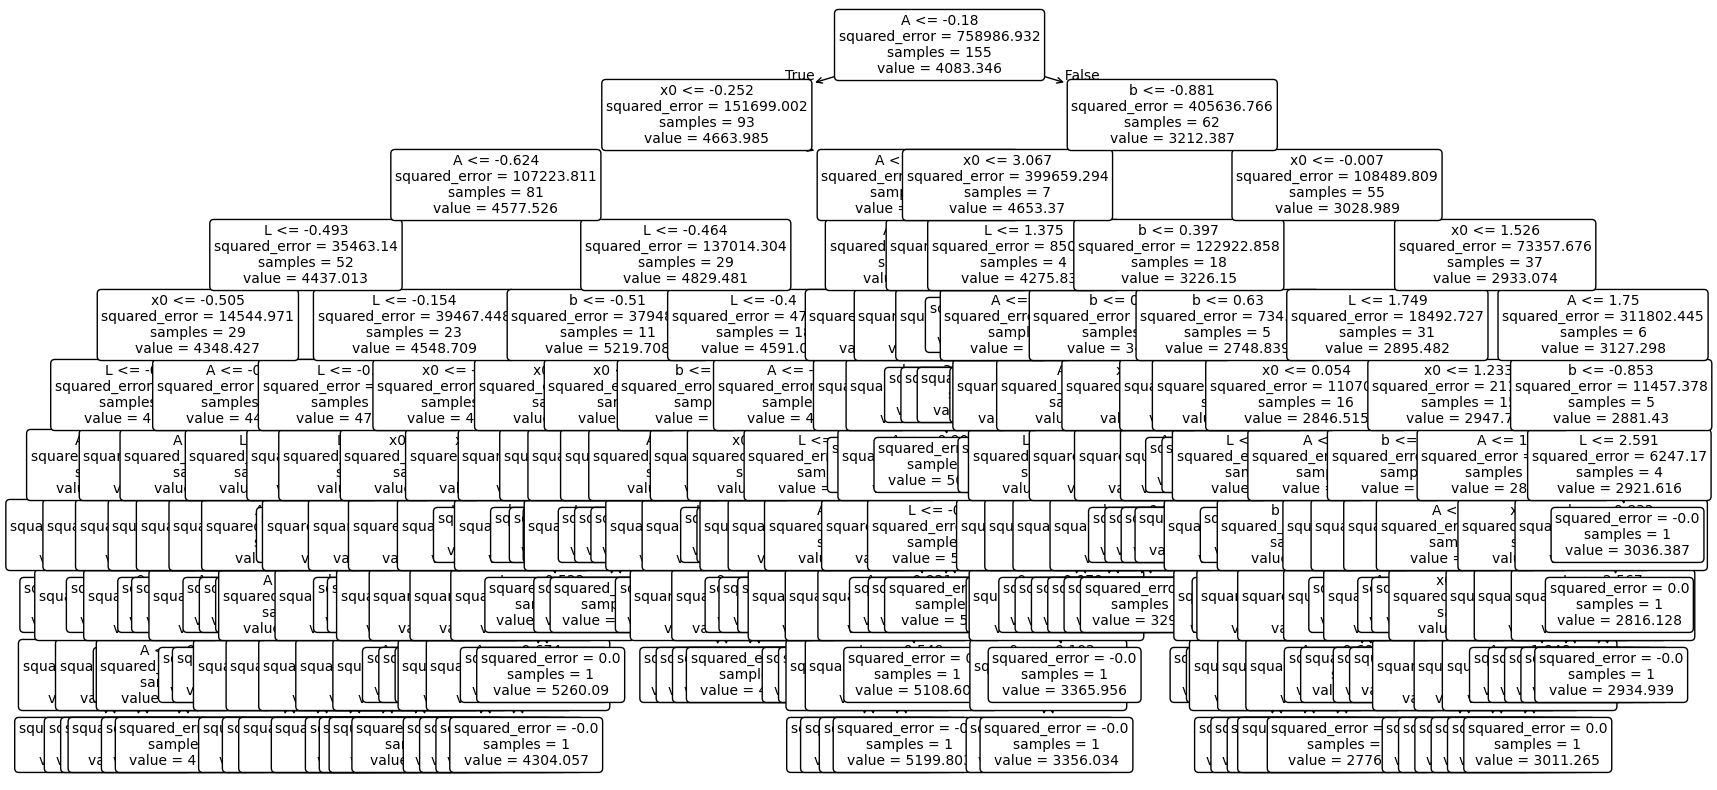

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the model
best_model = joblib.load('best_decision_tree_model.joblib')

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(best_model, 
          feature_names=features,  # Replace with your feature names
          # class_names=['class1', 'class2'],  # Replace with your class names if classification
          filled=False, 
          rounded=True, 
          fontsize=10)
plt.show()

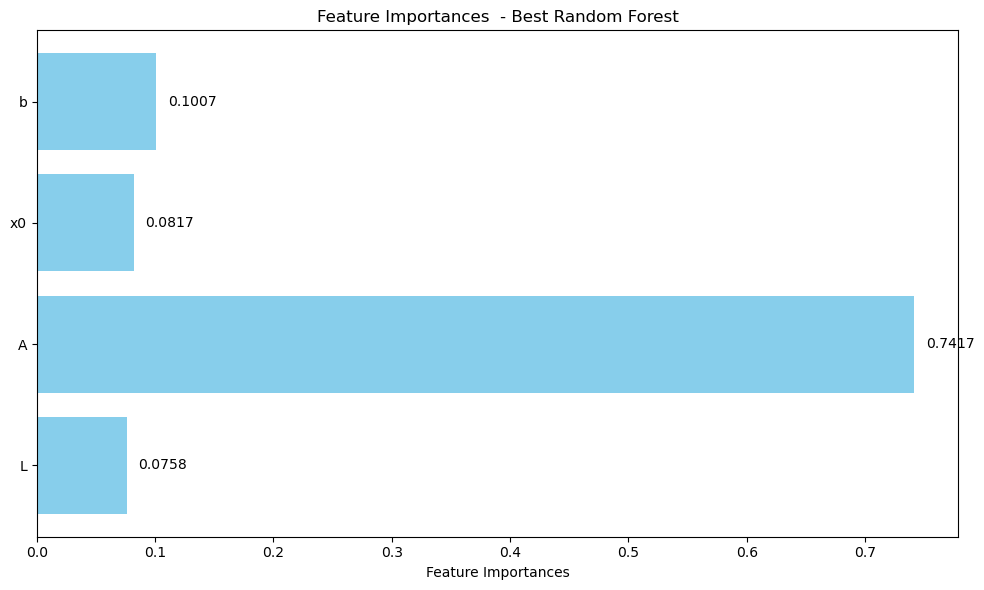

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importances')
plt.title('Feature Importances  - Best Random Forest')

# Annotate the plot with the actual coefficients
for i, (coef, feature) in enumerate(zip(importances, features)):
    plt.text(importances[i] + 0.01, i, f'{coef:.4f}', va='center')

plt.tight_layout()
plt.show()